In [1]:
pip install -r requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Note: you may need to restart the kernel to use updated packages.


In [2]:
## Imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import lifelines
import math
import statsmodels.api as sm
from lifelines.statistics import *
from scipy.stats import fisher_exact
import seaborn as sns
from HypernatremiaAnalysisFuncs import *

In [3]:
DATA_FOLDER = r'/Users/libi/Documents/Research/Hypernatremia/FinalVersions/ForGit'
DATA_FILE_NAME = r'Hypernatremia_combined_data_reduced.csv'
df = pd.read_csv(os.path.join(DATA_FOLDER, DATA_FILE_NAME))


/var/folders/by/rg8mq8fn4_34816gttqdcftc0000gn/T/ipykernel_54861/3635567545.py:3: DtypeWarning: Columns (113,146,187,223,226) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_FOLDER, DATA_FILE_NAME))


In [4]:
### Set parameters

INIT_SOD_THRESH_UPPER = 190
INIT_SOD_THRESH_LOWER = 155
CORR_RATE_OUTLIER_THRESH = 0.0005
THRESHOLDS = [-8, -10, -12]
HYP_ON_ADMISSION_COL = 'Hypernatremia admission 1 or hospitalization 2'
CORR_RATE_OVERALL_COL = 'Is_slow_corr_overall'
CORR_RATE_MAX_COL = 'Is_slow_maxcorr'
GENDER_COL = 'Gender 1 = M 2 =F'
MAX_RANGE = 15
LAB_RES_MAX_TD = 26
WEIGHTINGS_STR = 'fleming-harrington'

# Set Group colors
COLOR_DICT= {'color_on_ad_fast' : '#ca6702',
             'color_on_ad_slow' : '#94d2bd',
             'color_on_ad' : '#6a4c93',
             'color_hos_aq' : '#1982c4',
             'color_hos_aq_fast' : '#bb3e03',
             'color_hos_aq_slow' : '#005f73'}


In [5]:
#### Extract columns representing soduium correction rates and times

sodium_columns = df.iloc[:,[df.columns.get_loc(col) for col in df.columns if col.startswith('sodium') and ('numeric' in col)
                  and ('low' not in col) and ('urine' not in col)]]
initial_sod_col = sodium_columns.columns[0]

In [6]:
#### Remove patients with initial sodium levels not corresponding to severe hypernatremia

df = df[(df[initial_sod_col]>=INIT_SOD_THRESH_LOWER) & (df[initial_sod_col]<INIT_SOD_THRESH_UPPER)]
sodium_columns = sodium_columns[(sodium_columns[initial_sod_col]>=INIT_SOD_THRESH_LOWER) & \
                                (sodium_columns[initial_sod_col]<INIT_SOD_THRESH_UPPER)]

In [7]:
#%% Extract columns representing soduium correction rates and times

corr_rate_columns = df.iloc[:,[df.columns.get_loc(col) for col in df.columns if 'corection' in col]]
corr_hour_columns = df.iloc[:,[df.columns.get_loc(col) for col in df.columns if ('Reference' in col)
                               and ('Collection' in col) and ('sodium' in col) 
                               and ('lowest' not in col) and ('urine' not in col)]]
max_sodium = sodium_columns.idxmax(axis = 1)

In [8]:
#%% Clear rate outliers from all data frames

df, corr_rate_columns, sodium_columns, corr_hour_columns, \
    max_sodium = clear_outliers(df, corr_rate_columns,sodium_columns, corr_hour_columns, max_sodium, \
                               CORR_RATE_OUTLIER_THRESH)


 The number of rate outliers is: 21


/Users/libi/Documents/Research/Hypernatremia/FinalVersions/ForGit/HypernatremiaAnalysisFuncs.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_rate_cols.drop(index = outlier_indices, inplace=True)
/Users/libi/Documents/Research/Hypernatremia/FinalVersions/ForGit/HypernatremiaAnalysisFuncs.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_hour_cols.drop(index = outlier_indices, inplace=True)


In [9]:
#%% Calculate sodium correction within the time frame of first 24 hours following hypernatremia detection

sod_24_hour_df =  calculate_daily_sod_corr(sodium_columns, corr_hour_columns)
df = df.merge(sod_24_hour_df, how = 'inner', left_index=True, right_index=True)            
            
del sod_24_hour_df

In [10]:
#%% Caclculate Sodium correction-related columns

df = define_correction_columns(df, sodium_columns, corr_rate_columns, corr_hour_columns)

In [11]:
#%% Calculate supporting info (BUN/creatinine ratio, glucose outliers, ICU status)

df = create_BUN_creatinine_columns(df)
df = check_glucose_outliers(df)
df = check_if_from_ICU(df)

Num exceeding gluc threshold: 32


In [12]:
#%% Calculate Daily Correction Rates

df = daily_correction_above_threshs(df, THRESHOLDS)  

In [13]:
#%% Divide data into groups

on_admission = df[df[HYP_ON_ADMISSION_COL]==1]
on_hospitalization = df[df[HYP_ON_ADMISSION_COL]==2]

on_ad_low_rate = on_admission[on_admission[CORR_RATE_OVERALL_COL]==True] 
on_ad_high_rate = on_admission[on_admission[CORR_RATE_OVERALL_COL]==False]

on_hos_low_rate = on_hospitalization[on_hospitalization[CORR_RATE_OVERALL_COL]==True] 
on_hos_high_rate = on_hospitalization[on_hospitalization[CORR_RATE_OVERALL_COL]==False]

all_slow_rate = df[df[CORR_RATE_OVERALL_COL]==True]
all_high_rate = df[df[CORR_RATE_OVERALL_COL]==False]

# on_ad_max_corr_slow = on_admission[on_admission[CORR_RATE_MAX_COL]==True]
# on_ad_max_corr_fast= on_admission[on_admission[CORR_RATE_MAX_COL]==False]

# on_hos_max_corr_slow = on_hospitalization[on_hospitalization[CORR_RATE_MAX_COL]==True]
# on_hos_max_corr_fast= on_hospitalization[on_hospitalization[CORR_RATE_MAX_COL]==False]

# all_slow_max_rate = df[df[CORR_RATE_MAX_COL]==True]
# all_high_max_rate = df[df[CORR_RATE_MAX_COL]==False]

all_males = df[df[GENDER_COL]==1]
all_females = df[df[GENDER_COL]==2]

# reached_eunatremia_slow = all_slow_rate[all_slow_rate['Reached_normal']==True]
# reached_eunatremia_fast = all_high_rate[all_high_rate['Reached_normal']==True]

# no_eunatremia_slow = all_slow_rate[all_slow_rate['Reached_normal']==False]
# no_eunatremia_fast = all_high_rate[all_high_rate['Reached_normal']==False]


# slow_males = all_slow_rate[all_slow_rate[GENDER_COL]==1]
# slow_females = all_slow_rate[all_slow_rate[GENDER_COL]==2]

# fast_males = all_high_rate[all_high_rate[GENDER_COL]==1]
# fast_females = all_high_rate[all_high_rate[GENDER_COL]==2]

# hos_ac_males = on_hospitalization[on_hospitalization[GENDER_COL]==1]
# hos_ac_females = on_hospitalization[on_hospitalization[GENDER_COL]==2]

# on_ad_males = on_admission[on_admission[GENDER_COL]==1]
# on_ad_females = on_admission[on_admission[GENDER_COL]==2]

# on_hos_low_rate_males = on_hos_low_rate[on_hos_low_rate[GENDER_COL]==1]
# on_hos_low_rate_females = on_hos_low_rate[on_hos_low_rate[GENDER_COL]==2]

# on_hos_high_rate_males = on_hos_high_rate[on_hos_high_rate[GENDER_COL]==1]
# on_hos_high_rate_females = on_hos_high_rate[on_hos_high_rate[GENDER_COL]==2]

# on_ad_low_rate_males = on_ad_low_rate[on_ad_low_rate[GENDER_COL]==1]
# on_ad_low_rate_females = on_ad_low_rate[on_ad_low_rate[GENDER_COL]==2]

# on_ad_high_rate_males = on_ad_high_rate[on_ad_high_rate[GENDER_COL]==1]
# on_ad_high_rate_females = on_ad_high_rate[on_ad_high_rate[GENDER_COL]==2]





['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '>14']
PearsonRResult(statistic=-0.8059401724516109, pvalue=0.0002857066236996513)
Correlation between correct rate and mort_ratio is:  -0.8059
0      54.526749
1      51.911469
2      48.340249
3      49.354005
4      45.132743
5      40.650407
6      44.751381
7      35.877863
8      43.269231
9      44.736842
10     39.062500
11     43.548387
12     37.777778
13     41.025641
>14    26.086957
Name: Ratio, dtype: float64 0       0
1       1
2       2
3       3
4       4
5       5
6       6
7       7
8       8
9       9
10     10
11     11
12     12
13     13
>14    14
Name: ind, dtype: int64


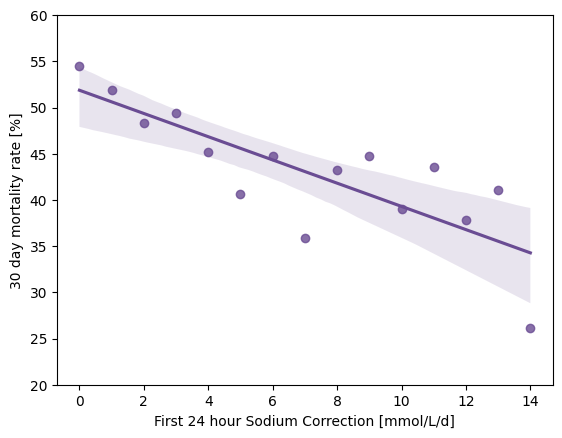

In [14]:
#%% Plot mortality vs daily correction rate bar plots

p = plot_mortality_vs_daily_corr_bar(df, COLOR_DICT['color_on_ad'], MAX_RANGE)

-1
Group Above size:  2813
Group Below size:  1454
Mortality Group Above:  1249 44.4
Mortality Group Below:  852 58.6
1.7722191041870041 1.3521444076818317e-18
Odds ratio:  1.77 [ 1.56 - 2.01 ]
Optimization terminated successfully.
         Current function value: 0.663966
         Iterations 5
Adjusted reg:OR= 1.84 [1.6  2.11]
-2
Group Above size:  2316
Group Below size:  1951
Mortality Group Above:  995 42.96
Mortality Group Below:  1106 56.69
1.7377134191668402 4.396903437701909e-19
Odds ratio:  1.74 [ 1.54 - 1.96 ]
Optimization terminated successfully.
         Current function value: 0.664508
         Iterations 5
Adjusted reg:OR= 1.76 [1.54 2.  ]
-3
Group Above size:  1848
Group Below size:  2419
Mortality Group Above:  757 40.96
Mortality Group Below:  1344 55.56
1.8018543209117999 3.67027915244061e-21
Odds ratio:  1.8 [ 1.59 - 2.04 ]
Optimization terminated successfully.
         Current function value: 0.663036
         Iterations 5
Adjusted reg:OR= 1.84 [1.62 2.11]
-4
Group A

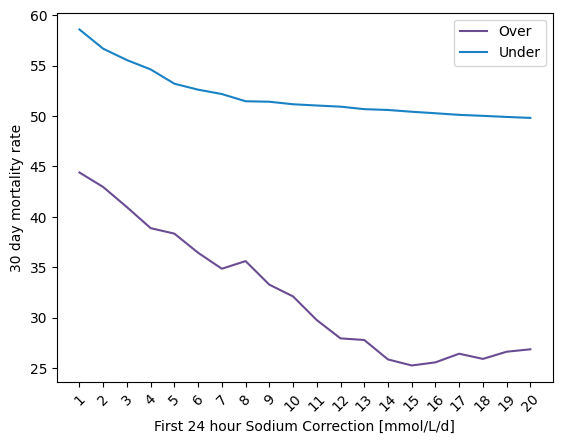

In [15]:
#%% Plot mortality vs continuous daily correction rate

cont_morr_rate_df = plot_mortality_vs_cont_daily_corr(df,  COLOR_DICT['color_on_ad'], COLOR_DICT['color_hos_aq'])

['Above', 'Below']
[64.39267886855241, 48.52700490998363]
#N Over:  601 Mortality:  214 Survivall:  387
#N Under:  3666 Mortality:  1887 Survivall:  1779
pval:  4.1571462764630426e-13
['Above', 'Below']
[67.89838337182448, 48.826291079812215]
#N Over:  433 Mortality:  139 Survivall:  294
#N Under:  3834 Mortality:  1962 Survivall:  1872
pval:  3.7238027488018496e-14
['Above', 'Below']
[72.06349206349206, 49.06376518218624]
#N Over:  315 Mortality:  88 Survivall:  227
#N Under:  3952 Mortality:  2013 Survivall:  1939
pval:  1.7530251986071614e-15


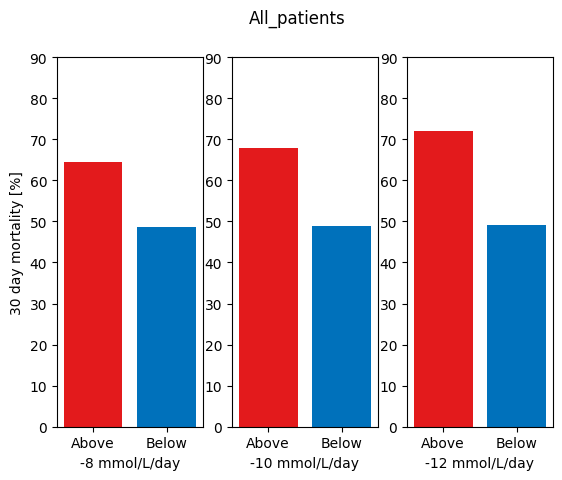

In [16]:
#%% Plot mortality vs daily correction rate bar plots across different thresholds

bar_allpats_30day = compare_mortality_across_daily_corrections(df, THRESHOLDS, 'All_patients')
# bar_allslow_30day = compare_mortality_across_daily_corrections(all_slow_rate, THRESHOLDS, 'All_slow')
# bar_allfast_30day =compare_mortality_across_daily_corrections(all_high_rate, THRESHOLDS, 'All_slow')

In [17]:
#%% Analyze group statistics (subgroup out of main group)


analyze_group_stats(on_ad_high_rate, on_admission, LAB_RES_MAX_TD)
# analyze_group_stats(on_ad_low_rate, on_admission, LAB_RES_MAX_TD)

# analyze_group_stats(on_hos_high_rate, on_hospitalization, LAB_RES_MAX_TD)
# analyze_group_stats(on_hos_low_rate, on_hospitalization, LAB_RES_MAX_TD)

# analyze_group_stats(all_high_rate, df, LAB_RES_MAX_TD)
# analyze_group_stats(all_slow_rate, df, LAB_RES_MAX_TD)

# analyze_group_stats(on_admission, df, LAB_RES_MAX_TD)
# analyze_group_stats(on_hospitalization, df, LAB_RES_MAX_TD)

# analyze_group_stats(df, df, LAB_RES_MAX_TD)
# analyze_group_stats(all_males, df, LAB_RES_MAX_TD )
# analyze_group_stats(all_females, df, LAB_RES_MAX_TD )

# analyze_group_stats(slow_males, all_slow_rate, LAB_RES_MAX_TD )
# analyze_group_stats(slow_females, all_slow_rate, LAB_RES_MAX_TD )

# analyze_group_stats(fast_males, all_high_rate, LAB_RES_MAX_TD )
# analyze_group_stats(fast_females, all_high_rate, LAB_RES_MAX_TD )

# analyze_group_stats(hos_ac_males, on_hospitalization, LAB_RES_MAX_TD )
# analyze_group_stats(hos_ac_females, on_hospitalization, LAB_RES_MAX_TD )

# analyze_group_stats(on_ad_males, on_admission, LAB_RES_MAX_TD )
# analyze_group_stats(on_ad_females, on_admission, LAB_RES_MAX_TD )

# analyze_group_stats(on_hos_low_rate_males, on_hos_low_rate, LAB_RES_MAX_TD)
# analyze_group_stats(on_hos_high_rate_males, on_hos_high_rate, LAB_RES_MAX_TD)

# analyze_group_stats(on_hos_low_rate_females, on_hos_low_rate, LAB_RES_MAX_TD)
# analyze_group_stats(on_hos_high_rate_females, on_hos_high_rate, LAB_RES_MAX_TD)

# analyze_group_stats(on_ad_low_rate_males, on_ad_low_rate, LAB_RES_MAX_TD)
# analyze_group_stats(on_ad_low_rate_females, on_ad_low_rate, LAB_RES_MAX_TD)

# analyze_group_stats(on_ad_high_rate_males, on_ad_high_rate, LAB_RES_MAX_TD)
# analyze_group_stats(on_ad_high_rate_females, on_ad_high_rate, LAB_RES_MAX_TD)

# analyze_group_stats(reached_eunatremia_slow, all_slow_rate, LAB_RES_MAX_TD)
# analyze_group_stats(reached_eunatremia_fast, all_high_rate, LAB_RES_MAX_TD)



Group size  112 ( 12 )
Group Age  84 ( 69 - 90 )
Gender - Males  42 ( 38 )
Gender - Females  70 ( 62 )
Charlson 0  8 ( 8 )
Charlson 1  5 ( 5 )
Charlson 2  5 ( 5 )
Charlson 3<=  86 ( 83 )
Total_charls_scores  104
Mean charlson score 4.923076923076923
Median charlson score 5.0 ( 4.0 - 7.0 )
7 day mortality  25 ( 22 )
30 day mortality  38 ( 34 )
1 year mortality  67 ( 60 )
Length of stay (days)  3.71 ( 2.02 - 6.08 )
charlson-AIDS 1=yes 0=no 1.0 ( 0.89 )
charlson-COPD 1= yes 0 = no 13.0 ( 11.61 )
charlson-Congestive Heart Failure 1= yes 0 = no 13.0 ( 11.61 )
charlson-Connective Tissue Disease 1= yes 0 = no 3.0 ( 2.68 )
charlson-Dementia 1= yes 0 = no 7.0 ( 6.25 )
charlson-Diabetes 1= End-Organ Damage 2 = Uncomplicated 3 = no or diet controled 277.0 ( 247.32 )
charlson-Hemiplegia or Paraplegia 1= yes 0 = no 1.0 ( 0.89 )
charlson-Peptic Ulcer Disease 1= yes 0 = no 1.0 ( 0.89 )
charlson-Leukemia 1= yes 0 = no 0.0 ( 0.0 )
charlson-Lymphoma 1= yes 0 = no 2.0 ( 1.79 )
charlson-Liver Disease 1= m

In [18]:
### Compare stats between two comparable groups
    
compare_general_stats(on_ad_low_rate,on_ad_high_rate)

# compare_general_stats(on_hos_low_rate, on_hos_high_rate)

# compare_general_stats(on_admission, on_hospitalization)

# compare_general_stats(all_slow_rate, all_high_rate)
    
# compare_general_stats(on_ad_low_rate, on_hos_low_rate)

# compare_general_stats(on_ad_high_rate, on_hos_high_rate)

# compare_general_stats(reached_eunatremia_slow, reached_euna÷tremia_fast)



Gender - Males 
1.9257340241796201 pval 0.0017061701514196669
Gender - Females 
0.5192825112107623 pval 0.0017061701514196669
Patients in ICU 
0.8039759593157652 pval 0.4630651384480985
Extreme hyperglycemic patients 
0.7124183006535948 pval 0.4848164405903734

 General 

Reference Event-Age at lab test
49741.0 0.2451250328363569
diagnosis at discharge-Diagnosis date-Days from Reference
38413.0 0.0005677668202812513

 Mortality columns 

7 day mortality 1 - Yes 0 - No
1.044 pval 0.9053556223930278
30 day mortality 1 - Yes 0 - No
1.777253478523896 pval 0.006339371244531301
1 year mortality 1 - Yes 0 - No
1.8342145773375276 pval 0.005016635099690872

 Comorbidities 

charlson-AIDS 1=yes 0=no 0.2674698795180723 pval 0.31566641774496174
charlson-COPD 1= yes 0 = no 0.5706618962432916 pval 0.08656246386085852
charlson-Congestive Heart Failure 1= yes 0 = no 0.5181198775550508 pval 0.04854752491891624
charlson-Connective Tissue Disease 1= yes 0 = no 0.5317073170731708 pval 0.4070743367840783
c

On Admission - CR<=0.5 mmol/L/h
First sod:  158.0 ( 156.0 - 162.0 )
<class 'pandas.core.series.Series'>
Index: 832 entries, 11 to 4304
Series name: sodium 1-Result numeric
Non-Null Count  Dtype  
--------------  -----  
832 non-null    float64
dtypes: float64(1)
memory usage: 13.0 KB
None


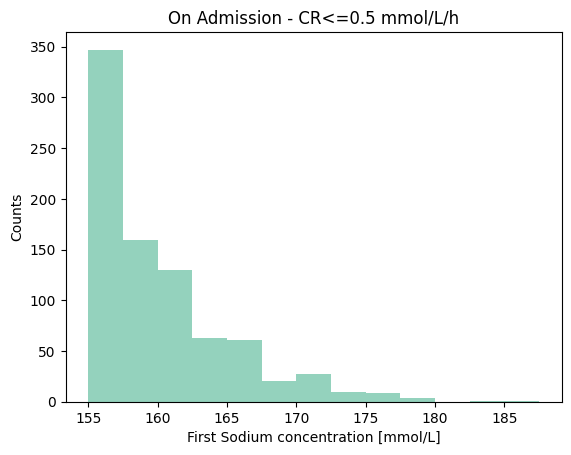

First corrected sod:  145.0 ( 142.0 - 151.0 )


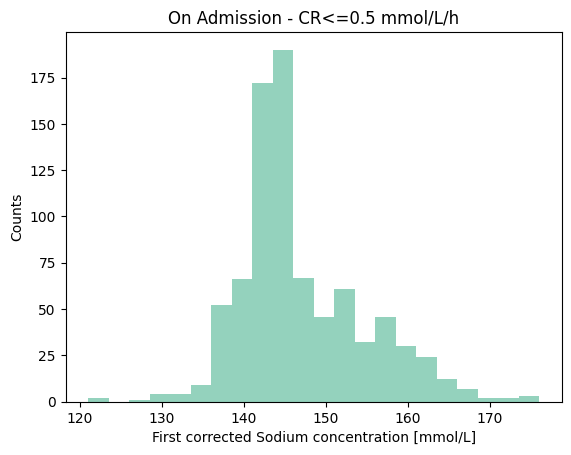

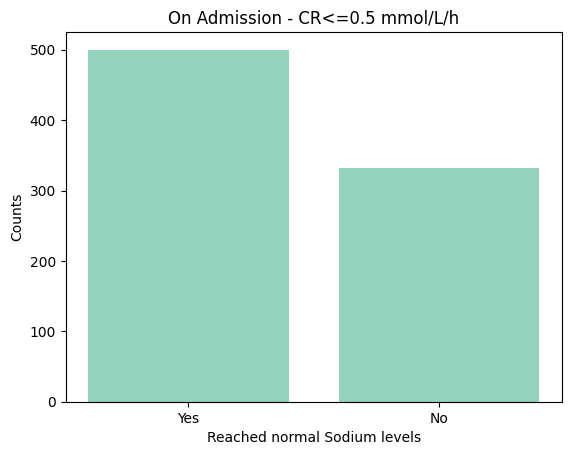

Reached corrected levels :  500 ( 60.1 )


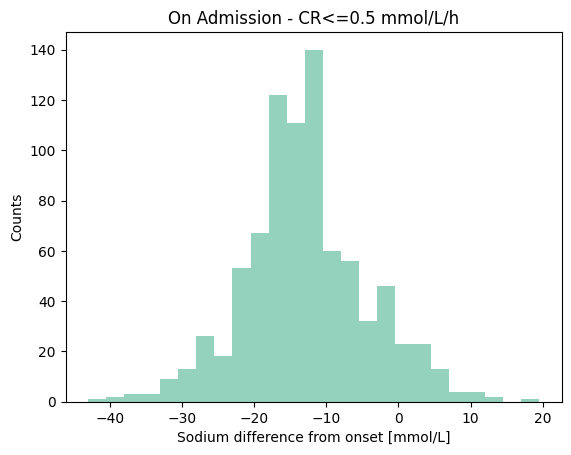

Sodium difference from onset:  -14.0 ( -18.0 - -9.0 )


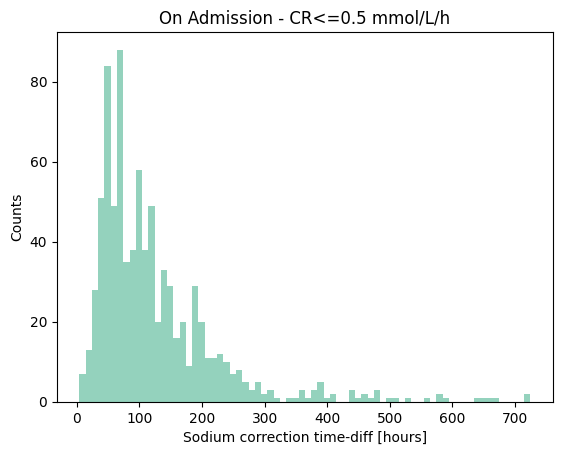

Time to Sodium correction:  96.27 ( 60.1 - 155.97 )


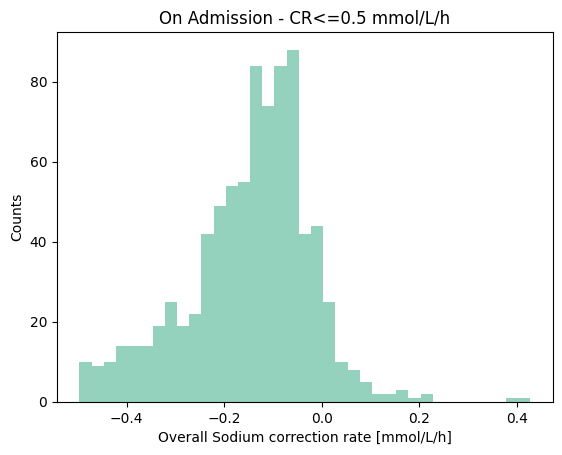

Overall Sodium correction rate:  -0.13 ( -0.21 - -0.07 )


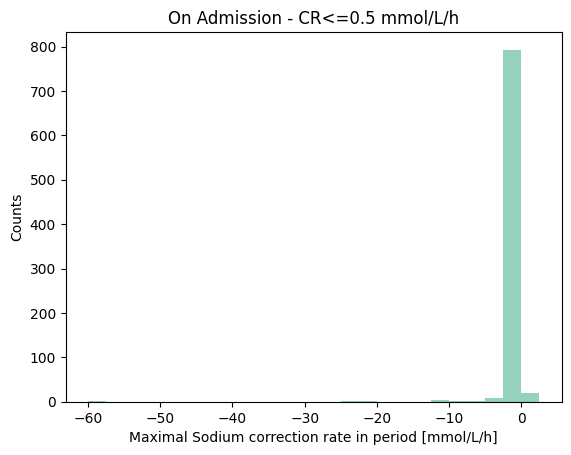

Maximal Sodium correction rate:  -0.31 ( -0.52 - -0.19 )


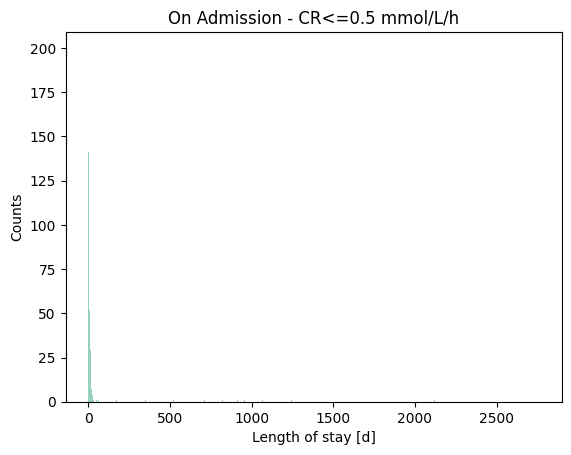

Length of stay in the hospital:  4.94 ( 2.89 - 9.85 )
Correction during first 24-hours:  -3.5 ( -6.51 - -0.71 )


In [19]:
#%% Accessory plots of sodium levels in different groups    

group_name = 'On Admission - CR<=0.5 mmol/L/h'
analyze_group_sodium(on_ad_low_rate, group_name, COLOR_DICT['color_on_ad_slow'])



In [20]:
#%% Compare Sodium stats between two matching groups


compare_group_sodium_stats(on_ad_low_rate,on_ad_high_rate)
# compare_group_sodium_stats(on_hos_low_rate, on_hos_high_rate)
# compare_group_sodium_stats(on_hospitalization, on_admission)
# compare_group_sodium_stats(all_slow_rate, all_high_rate)


sodium 1-Result numeric
36617.5 0.00021530104685849253
First_under145
69256.0 5.085377612251549e-17
Sod_diff_from_onset
70528.0 9.2762938934004e-19
First_time_under145
89587.0 9.988148803635344e-57
First_under145_overall_corr_rate
93184.0 2.6871723035534883e-66
Fastest_correction_rate
82819.0 8.689955177899639e-41
diagnosis at discharge-Diagnosis date-Days from Reference
38413.0 0.0005677668202812513
Proportion reached correction
0.19776073992941462 pval 5.373329091965509e-10


Compare at 30 days


<lifelines.StatisticalResult: survival_difference_at_fixed_point_in_time_test>
 null_distribution = chi squared
degrees_of_freedom = 1
     point_in_time = 30
           fitterA = <lifelines.KaplanMeierFitter:"$\leq$0.5 mmol/L/h", fitted with 832 total observations, 102 right-censored observations>
           fitterB = <lifelines.KaplanMeierFitter:">0.5 mmol/L/h", fitted with 112 total observations, 28 right-censored observations>
         test_name = survival_difference_at_fixed_point_in_time_test

---
 test_statistic    p  -log2(p)
           6.84 0.01      6.81

0.008909191420291781
Hypernatremia on admission - KM survival plots
Log-rank test


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          11.40 <0.005     10.41

0.0007355845318071321
11.397109951742312

 Flemington-harrington


<lifelines.StatisticalResult: Flemington-Harrington_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
                 p = 1
                 q = 0
         test_name = Flemington-Harrington_test

---
 test_statistic    p  -log2(p)
           6.79 0.01      6.77

0.009160257181845675
6.79131180561012


<lifelines.BreslowFlemingHarringtonFitter:"$\leq$0.5 mmol/L/h", fitted with 832 total observations, 102 right-censored observations>

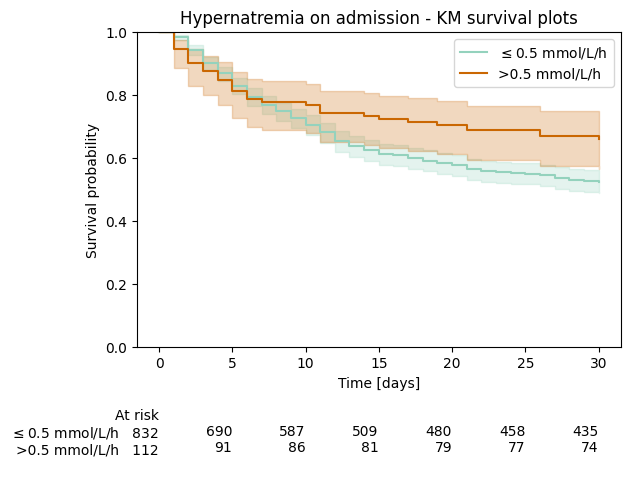

In [21]:
#%% Kaplen-Mayer curves

KM_title_adm = 'Hypernatremia on admission - KM survival plots'    
plot_KaplanMayer_curve(on_ad_low_rate, on_ad_high_rate, r'$\leq$0.5 mmol/L/h',
                        '>0.5 mmol/L/h', KM_title_adm, COLOR_DICT['color_on_ad_slow'],
                        COLOR_DICT['color_on_ad_fast'], WEIGHTINGS_STR, 'OnAdForMCTest')

# KM_title_hos = 'Hypernatremia hospital acquired - KM survival plots'    
# plot_KaplanMayer_curve(on_hos_low_rate, on_hos_high_rate, r'Rate $\leq$0.5 mmol/L/h',
#                         'Rate >0.5 mmol/L/h', KM_title_hos, COLOR_DICT['color_hos_aq_slow'],
#                         COLOR_DICT['color_hos_aq_fast'], WEIGHTINGS_STR , 'HosAqForMCTest')

# KM_title_all = 'Survival probability according to hypernatremia correction rate'    
# fhr_a_test = plot_KaplanMayer_curve(all_slow_rate, all_high_rate, r'$\leq$0.5 mmol/L/h',
#                         '>0.5 mmol/L/h', KM_title_all, COLOR_DICT['color_hos_aq'],
#                         COLOR_DICT['color_on_ad'], WEIGHTINGS_STR, 'AllPatsForMCTest')





In [22]:
#%% Logistic regression analysis of mortality odds ratio

na_res, extended_adj_res = analyze_mortality_odds_ratio(on_ad_low_rate,
                            on_ad_high_rate, 'On admission slow vs. fast')    

# na_res, extended_adj_res = analyze_mortality_odds_ratio(on_hos_low_rate,
#                             on_hos_high_rate, 'Hospital acq. slow vs. fast')  


# na_res, extended_adj_res = analyze_mortality_odds_ratio(on_ad_max_corr_slow, on_ad_max_corr_fast,
#                               'On admission slow vs. fast max corr. rate')    
# na_res, extended_adj_res = analyze_mortality_odds_ratio(on_hos_max_corr_slow, on_hos_max_corr_fast,
#                               'Hospital acq. slow vs. fast max corr. rate')    
    
# na_res, extended_adj_res = analyze_mortality_odds_ratio(all_slow_rate, all_high_rate,
#                               'Fast vs. Slow correction rate')    


# na_res, extended_adj_res = analyze_mortality_odds_ratio(all_slow_max_rate, all_high_max_rate,
#                               'Fast vs. Slow max correction rate')        



On admission slow vs. fast
Group A size:  832
Group B size:  112
Mortality Group A:  397 47.72
Mortality Group B:  38 33.93
1.777253478523896 0.006339371244531301
Odds ratio:  1.78 ( 1.17 - 2.69 )

 Num of patients in final analysis:
(896, 9) 

Optimization terminated successfully.
         Current function value: 0.685989
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  944
Model:                          Logit   Df Residuals:                      942
Method:                           MLE   Df Model:                            1
Date:                Tue, 27 Jan 2026   Pseudo R-squ.:                0.005917
Time:                        16:30:52   Log-Likelihood:                -647.57
converged:                       True   LL-Null:                       -651.43
Covariance Type:            nonrobust   LLR p-value:                  0.005495
                 coef